# Importing Dependencies

In [1]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 418.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.5/150.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [2]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [4]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 15.2 MB/s eta 0:00:00


In [5]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.9 MB/s eta 0:00:00


In [6]:
import json
import pandas as pd
import numpy as np
import torch
import faiss
import spacy
from tqdm import tqdm, trange
from datasets import load_dataset

from sentence_transformers import SentenceTransformer
from transformers import BartTokenizer, BartForConditionalGeneration

from langchain.chains import SimpleSequentialChain
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from langchain.chains.base import Chain

from typing import Dict, List
from pydantic import BaseModel, Field

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer


# Fetching the dataset

In [7]:
# configuring the path of kaggle.json file

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# API to Fetch dataset from kaggle

!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.32G/1.32G [00:34<00:00, 42.3MB/s]
100% 1.32G/1.32G [00:34<00:00, 40.9MB/s]


In [9]:
# Extracting the compressed Dataset

from zipfile import ZipFile
dataset = '/content/arxiv.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [10]:
# Load the JSON file and extract the first 1000 rows
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    arxiv_data = []
    for i, line in enumerate(file):
        if i >= 1000:  # Limit to the first 1000 rows
            break
        arxiv_data.append(json.loads(line))

In [11]:
# Convert to DataFrame and keep only relevant columns
df = pd.DataFrame(arxiv_data)[['id', 'authors', 'title', 'categories', 'abstract', 'update_date']]

In [12]:
df

,id,authors,title,categories,abstract,update_date
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15
...,...,...,...,...,...,...
995,0704.0996,"Anurag Sahay, Gautam Sengupta",Brane World Black Rings,hep-th,Five dimensional neutral rotating black ring...,2009-11-13
996,0704.0997,Dan Coman and Evgeny A. Poletsky,Stable algebras of entire functions,math.CV,Suppose that $h$ and $g$ belong to the algeb...,2007-05-23
997,0704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23
998,0704.0999,G. Lusztig,Generic character sheaves on disconnected grou...,math.RT,We relate a generic character sheaf on a dis...,2007-05-23


# Data Exploration & Feature Engineering

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1000 non-null   object
 1   authors      1000 non-null   object
 2   title        1000 non-null   object
 3   categories   1000 non-null   object
 4   abstract     1000 non-null   object
 5   update_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [14]:
df.describe()

,id,authors,title,categories,abstract,update_date
count,1000,1000,1000,1000,1000,1000
unique,1000,965,1000,309,998,256
top,0704.1000,I. Grabec,Measurement of D0-D0bar mixing in D0->Ks pi+ p...,astro-ph,The Klein-Gordon equation in D-dimensions fo...,2007-05-23
freq,1,4,1,179,2,204


In [15]:
# Check distribution of categories
print(df['categories'].value_counts())

categories
astro-ph                              179
quant-ph                               42
hep-th                                 40
hep-ph                                 37
cond-mat.mes-hall                      29
                                     ... 
math.PR math.AG                         1
nlin.PS physics.chem-ph q-bio.MN        1
nlin.PS                                 1
cond-mat.str-el cond-mat.stat-mech      1
math.CA math.PR                         1
Name: count, Length: 309, dtype: int64


In [16]:
# Explore the distribution of update dates
df['update_date'] = pd.to_datetime(df['update_date'])
df['year'] = df['update_date'].dt.year
print(df['year'].value_counts())

year
2009    335
2007    299
2008    193
2015     36
2010     34
2011     25
2016     18
2012     17
2013     10
2014      9
2019      9
2017      4
2023      3
2022      2
2021      2
2020      2
2024      1
2018      1
Name: count, dtype: int64


In [17]:
# Add a column for the length of the abstract
df['abstract_length'] = df['abstract'].apply(len)

In [18]:
# Add a column for the number of authors
df['number_of_authors'] = df['authors'].apply(lambda x: len(x.split(',')))

In [19]:
df

,id,authors,title,categories,abstract,update_date,year,abstract_length,number_of_authors
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26,2008,983,4
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,2008,798,1
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13,2008,880,1
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23,2007,248,1
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15,2013,223,1
...,...,...,...,...,...,...,...,...,...
995,0704.0996,"Anurag Sahay, Gautam Sengupta",Brane World Black Rings,hep-th,Five dimensional neutral rotating black ring...,2009-11-13,2009,906,2
996,0704.0997,Dan Coman and Evgeny A. Poletsky,Stable algebras of entire functions,math.CV,Suppose that $h$ and $g$ belong to the algeb...,2007-05-23,2007,413,1
997,0704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23,2007,548,1
998,0704.0999,G. Lusztig,Generic character sheaves on disconnected grou...,math.RT,We relate a generic character sheaf on a dis...,2007-05-23,2007,213,1


In [20]:
# Drop the specified columns
df = df.drop(['year', 'abstract_length'], axis=1)

In [21]:
# Combine title and abstract for easier processing
df['content'] = df['title'] + ' ' + df['abstract']

In [22]:
df

,id,authors,title,categories,abstract,update_date,number_of_authors,content
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26,4,Calculation of prompt diphoton production cros...
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,1,Sparsity-certifying Graph Decompositions We ...
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13,1,The evolution of the Earth-Moon system based o...
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23,1,A determinant of Stirling cycle numbers counts...
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15,1,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...
...,...,...,...,...,...,...,...,...
995,0704.0996,"Anurag Sahay, Gautam Sengupta",Brane World Black Rings,hep-th,Five dimensional neutral rotating black ring...,2009-11-13,2,Brane World Black Rings Five dimensional neu...
996,0704.0997,Dan Coman and Evgeny A. Poletsky,Stable algebras of entire functions,math.CV,Suppose that $h$ and $g$ belong to the algeb...,2007-05-23,1,Stable algebras of entire functions Suppose ...
997,0704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23,1,"Test vectors for trilinear forms, when two rep..."
998,0704.0999,G. Lusztig,Generic character sheaves on disconnected grou...,math.RT,We relate a generic character sheaf on a dis...,2007-05-23,1,Generic character sheaves on disconnected grou...


In [23]:
df = df.head(1000)

In [24]:
# Convert to a list of documents
documents = df['content'].tolist()

# Document Retrieval using Sentence Embeddings and FAISS

In [26]:
# Load the SentenceTransformer model (use GPU if available)

model = SentenceTransformer('all-mpnet-base-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
# Initialize an empty list to store embeddings
all_embeddings = []

# Process and encode documents in batches
batch_size = 100  # Adjust based on available memory
for i in tqdm(range(0, len(documents), batch_size), desc="Encoding batches"):
    batch_texts = documents[i:i+batch_size]
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Normalize embeddings for cosine similarity search
    batch_embeddings = batch_embeddings / np.linalg.norm(batch_embeddings, axis=1, keepdims=True)

    all_embeddings.append(batch_embeddings)

# Concatenate all embeddings
embeddings = np.vstack(all_embeddings)

Encoding batches: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


In [28]:
# Compress the FAISS index for memory efficiency
d = embeddings.shape[1]  # Dimensionality of embeddings
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFPQ(quantizer, d, 100, 8, 8)  # Use IVF and PQ for compression


In [29]:
# Train the index (necessary for IVF)
index.train(embeddings)
index.add(embeddings)

In [30]:
# Save the index
faiss.write_index(index, "arxiv_papers_faiss.index")

## Query the FAISS Index

In [31]:
def search_documents(query, model, index, df, top_k=5):
    # Encode the query
    query_embedding = model.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search the index for similar documents
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve the top-k documents
    results = df.iloc[indices[0]].copy()
    results['similarity'] = distances[0]
    return results

In [32]:
# Example query
query = "machine learning algorithms in physics"
results = search_documents(query, model, index, df)
print(results[['title', 'abstract', 'similarity']])

                                                 title  \
610  Modeling the field of laser welding melt pool ...   
88   A general approach to statistical modeling of ...   
161  Estimation of experimental data redundancy and...   
106             Experimental modeling of physical laws   
150  Extraction of physical laws from joint experim...   

                                              abstract  similarity  
610    Efficient control of a laser welding process...    0.796656  
88     Statistical modeling of experimental physica...    0.797031  
161    Redundancy of experimental data is the basic...    0.841317  
106    A physical law is represented by the probabi...    0.888470  
150    The extraction of a physical law y=yo(x) fro...    0.888470  


# Summarization using BART

In [33]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)

# Define the generate_summary function
def generate_summary(text, tokenizer, model, device):
    inputs = tokenizer([text], max_length=1024, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=100, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [34]:
# Generate summaries for the search results
results['summary'] = results['abstract'].apply(lambda x: generate_summary(x, tokenizer, model, device))
print(results[['title', 'summary']])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


                                                 title  \
610  Modeling the field of laser welding melt pool ...   
88   A general approach to statistical modeling of ...   
161  Estimation of experimental data redundancy and...   
106             Experimental modeling of physical laws   
150  Extraction of physical laws from joint experim...   

                                               summary  
610  A statistical method of field modeling can be ...  
88   Physical law is expressed by experimental data...  
161  Redundancy of experimental data is the basic s...  
106  A physical law is represented by the probabili...  
150  The extraction of a physical law y=yo(x) from ...  


# Integrate LangChain for Workflow Management



```
# LangChain can manage document retrieval, summarization, and interaction.
```



In [35]:
from sentence_transformers import SentenceTransformer
from langchain.chains import SimpleSequentialChain
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from transformers import BartTokenizer, BartForConditionalGeneration
from langchain.chains.base import Chain
from typing import Dict, List
from pydantic import BaseModel, Field

class FaissRetrievalChain(Chain):
    index: faiss.IndexIVFPQ = Field(...)  # Define index as a field with type hint faiss.IndexIVFPQ
    df: object  # Add type hint for df if available, otherwise use 'object'
    model: SentenceTransformer = Field(...)  # Define model as a field with type hint SentenceTransformer

    def _call(self, inputs: Dict[str, str]) -> Dict[str, str]:
        # Implement the logic for retrieving documents using FAISS
        query = inputs["query"]
        results = search_documents(query, self.model, self.index, self.df, top_k = 1)
        return {"abstract": results.iloc[0]['abstract']}

    @property
    def input_keys(self) -> List[str]:
        # Define the input keys for the chain
        return ["query"]

    @property
    def output_keys(self) -> List[str]:
        # Define the output keys for the chain
        return ["abstract"]

class BARTSummarizationChain(Chain): # Inherit from langchain.chains.base.Chain
    tokenizer: BartTokenizer = Field(...)  # Define tokenizer as a field with type hint BartTokenizer
    model: BartForConditionalGeneration = Field(...)  # Define model as a field with type hint BartForConditionalGeneration
    device: str = Field(...)  # Define device as a field with type hint str

    def _call(self, inputs: Dict[str, str]) -> Dict[str, str]: # Implement the _call method
        # Access the abstract from the inputs and generate the summary
        abstract = inputs["abstract"]
        summary = generate_summary(abstract, self.tokenizer, self.model, self.device)
        return {"summary": summary}

    @property
    def input_keys(self) -> List[str]:  # Define input_keys
        return ["abstract"]

    @property
    def output_keys(self) -> List[str]:  # Define output_keys
        return ["summary"]


def search_documents(query, model, index, df, top_k=5):
    # Encode the query
    query_embedding = model.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search the index for similar documents
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve the top-k documents
    results = df.iloc[indices[0]].copy()
    results['similarity'] = distances[0]
    return results

# Load the SentenceTransformer model
embedding_model = SentenceTransformer('all-mpnet-base-v2') # Replace with your desired model

# Assuming you have a SentenceTransformer model named 'embedding_model'
faiss_chain = FaissRetrievalChain(index=index, df=df, model=embedding_model) # Use the correct SentenceTransformer model here

# Use the 'tokenizer' variable here instead of 'bart_tokenizer'
bart_chain = BARTSummarizationChain(tokenizer=tokenizer, model=model, device=device.type)

# Sequentially apply the Faiss retrieval and BART summarization chains
chain = SimpleSequentialChain(chains=[faiss_chain, bart_chain])

In [36]:
# Example usage
query = "machine learning in physics"
result = chain.run(query)
print(result)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


Physical law is expressed by experimental data via a kernel estimator. The kernel is determined objectively by the scattering of data during calibration of experimental setup. The mean predictorerror is used in the definition of predictor quality, while the redundancy isexpressed by the mean square distance between data points. The proposed method is demonstrated by the modeling of a return map of noisy chaotic data.


# Apply NLP Techniques for Enhanced Search and Analysis

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Example: Extract keywords using TF-IDF
tfidf = TfidfVectorizer(max_features=10)
keywords = tfidf.fit_transform(df['abstract'])
pca = PCA(n_components=2)
reduced_keywords = pca.fit_transform(keywords.toarray())

# Add keywords to the DataFrame

# Use keywords instead of tfidf_matrix
df.loc[:, 'keywords'] = [' '.join([tfidf.get_feature_names_out()[i] for i in row.indices]) for row in keywords]


<ipython-input-37-5341ce7b31c0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'keywords'] = [' '.join([tfidf.get_feature_names_out()[i] for i in row.indices]) for row in keywords]





> We can also apply NLP techniques like Named Entity Recognition (NER) and keyword extraction for better query understanding.




In [38]:
import spacy

# Load Spacy model for NER
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
#    return "entities_from_" + text
    return entities

# Apply NER to the abstracts

# Working on a copy of the DataFrame
df_copy = df.copy()
df_copy['entities'] = df_copy['abstract'].apply(extract_entities)

# Print the modified DataFrame
print(df_copy)

            id                                            authors  \
0    0704.0001  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1    0704.0002                    Ileana Streinu and Louis Theran   
2    0704.0003                                        Hongjun Pan   
3    0704.0004                                       David Callan   
4    0704.0005           Wael Abu-Shammala and Alberto Torchinsky   
..         ...                                                ...   
995  0704.0996                      Anurag Sahay, Gautam Sengupta   
996  0704.0997                   Dan Coman and Evgeny A. Poletsky   
997  0704.0998                                Louise Nyssen (I3M)   
998  0704.0999                                         G. Lusztig   
999  0704.1000    L.M. Zhang, et al (for the Belle Collaboration)   

                                                 title       categories  \
0    Calculation of prompt diphoton production cros...           hep-ph   
1             Sparsit

# Document Classification



> Classify papers based on the **categories** column:



In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

# Multi-label binarization for categories
mlb = MultiLabelBinarizer()
df_copy['categories_list'] = df_copy['categories'].apply(lambda x: x.split())

# Use df_copy here instead of df
categories_matrix = mlb.fit_transform(df_copy['categories_list'])

# You can use this matrix to train classification models.

In [40]:
# Print the modified DataFrame using display()
display(df_copy)

,id,authors,title,categories,abstract,update_date,number_of_authors,content,keywords,entities,categories_list
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26,4,Calculation of prompt diphoton production cros...,that with and to of the for is in,"[(the Fermilab Tevatron, ORG), (CDF, ORG), (di...",[hep-ph]
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,1,Sparsity-certifying Graph Decompositions We ...,we that with and to of the in,"[(recent years, DATE), (Lee, GPE), (Streinu, G...","[math.CO, cs.CG]"
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13,1,The evolution of the Earth-Moon system based o...,that with and to of the for is in,"[(Earth, LOC), (the Meeting of Division of Par...",[physics.gen-ph]
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23,1,A determinant of Stirling cycle numbers counts...,we that and to of the,"[(Stirling, ORG)]",[math.CO]
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15,1,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,we and to of the is in,"[(\Lambda_{\alpha}$, PERSON), (\alpha\ge, MONE...","[math.CA, math.FA]"
...,...,...,...,...,...,...,...,...,...,...,...
995,0704.0996,"Anurag Sahay, Gautam Sengupta",Brane World Black Rings,hep-th,Five dimensional neutral rotating black ring...,2009-11-13,2,Brane World Black Rings Five dimensional neu...,we with and to of the in,"[(Five, CARDINAL), (five, CARDINAL), (six, CAR...",[hep-th]
996,0704.0997,Dan Coman and Evgeny A. Poletsky,Stable algebras of entire functions,math.CV,Suppose that $h$ and $g$ belong to the algeb...,2007-05-23,1,Stable algebras of entire functions Suppose ...,we that and to of the is in,"[(\B$, PERSON), ({\Bbb, PERSON), ($q_1,q_2$, M...",[math.CV]
997,0704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23,1,"Test vectors for trilinear forms, when two rep...",and to of the for is in,"[(Qp, PERSON), (three, CARDINAL), (zero, CARDI...",[math.NT]
998,0704.0999,G. Lusztig,Generic character sheaves on disconnected grou...,math.RT,We relate a generic character sheaf on a dis...,2007-05-23,1,Generic character sheaves on disconnected grou...,we with of the in,[],[math.RT]


In [41]:
df

,id,authors,title,categories,abstract,update_date,number_of_authors,content,keywords
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26,4,Calculation of prompt diphoton production cros...,that with and to of the for is in
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,1,Sparsity-certifying Graph Decompositions We ...,we that with and to of the in
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13,1,The evolution of the Earth-Moon system based o...,that with and to of the for is in
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23,1,A determinant of Stirling cycle numbers counts...,we that and to of the
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15,1,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,we and to of the is in
...,...,...,...,...,...,...,...,...,...
995,0704.0996,"Anurag Sahay, Gautam Sengupta",Brane World Black Rings,hep-th,Five dimensional neutral rotating black ring...,2009-11-13,2,Brane World Black Rings Five dimensional neu...,we with and to of the in
996,0704.0997,Dan Coman and Evgeny A. Poletsky,Stable algebras of entire functions,math.CV,Suppose that $h$ and $g$ belong to the algeb...,2007-05-23,1,Stable algebras of entire functions Suppose ...,we that and to of the is in
997,0704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23,1,"Test vectors for trilinear forms, when two rep...",and to of the for is in
998,0704.0999,G. Lusztig,Generic character sheaves on disconnected grou...,math.RT,We relate a generic character sheaf on a dis...,2007-05-23,1,Generic character sheaves on disconnected grou...,we with of the in


# Topic Modeling with LDA

> Implement topic modeling using **Latent Dirichlet Allocation** (LDA) to identify topics in the documents and visualize document clusters.



*  **LDA:** Uses a probabilistic approach to model topics.


In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing the data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['abstract'])

# Count Vectorizer for LDA
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
count = count_vectorizer.fit_transform(df['abstract'])


In [43]:
# LDA Model
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(count)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 1:
10 evolution star function using models field different results obtained
Topic 2:
model energy ray problem high gamma theory state point observations
Topic 3:
energy using results state model theory data density analysis range
Topic 4:
quantum field model theory results wave state space dimensional states
Topic 5:
pi model phase quark structure results pm rm states molecular
Topic 6:
quantum large planets networks mass based network planet systems present
Topic 7:
model results time order functions function energy non new type
Topic 8:
galaxies mass star emission stars type cluster observations formation high
Topic 9:
data energy number function model new algorithm study experimental states
Topic 10:
spin field magnetic theory phase model dimensional coupling quantum order


### Visualizing Topic Clusters

*   **LDA Plot:** Each distinct color indicates a unique topic derived from Latent Dirichlet Allocation (LDA). The data points clustered together with the same color are associated with the same topic.



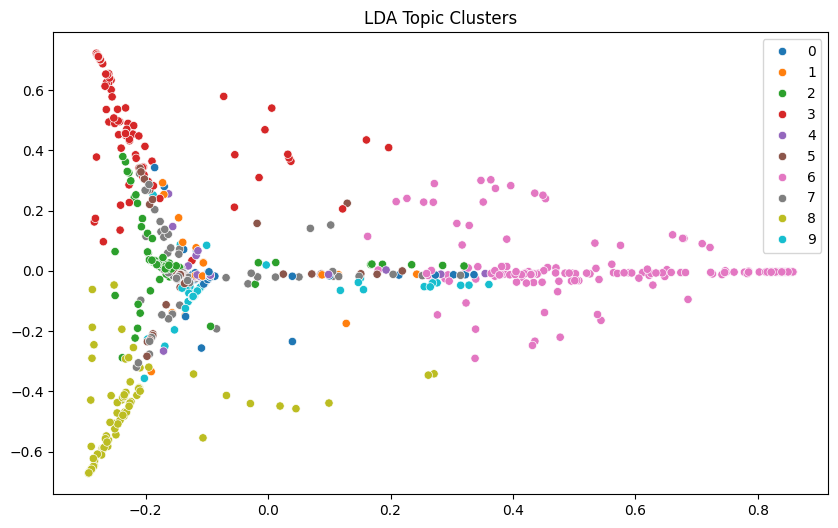

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get the topic distribution for each document
lda_transformed = lda.transform(count)

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
lda_pca = pca.fit_transform(lda_transformed)

# Plotting LDA Topics
plt.figure(figsize=(10, 6))
sns.scatterplot(x=lda_pca[:, 0], y=lda_pca[:, 1], hue=lda_transformed.argmax(axis=1), palette='tab10')
plt.title('LDA Topic Clusters')
plt.show()

### Coherence Score Calculation

In [45]:
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Convert the processed documents into a format suitable for Gensim
texts = [doc.split() for doc in df['content']]  # Assuming content is preprocessed
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Load or train LDA model (assuming you've already done topic modeling)
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_score}')


Coherence Score: 0.24864013032334364




*   A coherence score of 0.2486 for your LDA topic model is quite low.

*   Coherence scores generally range from 0 to 1, with higher scores indicating more meaningful and interpretable topics.



### Enhanced Data Preprocessing

In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt') # Download the Punkt sentence tokenizer

# Convert to a list of documents
documents = df['content'].tolist()

# Preprocessing pipeline
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_docs = []

for doc in documents:
    # 1. Lowercase and tokenize
    tokens = nltk.word_tokenize(doc.lower())

    # 2. Remove stop words and punctuation
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]

    # 3. Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    processed_docs.append(tokens)

print(processed_docs)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[['calculation', 'prompt', 'diphoton', 'production', 'cross', 'section', 'tevatron', 'lhc', 'energy', 'fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamics', 'presented', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'order', 'perturbative', 'contribution', 'anti', 'quark', 'subprocesses', 'included', 'well', 'resummation', 'gluon', 'radiation', 'valid', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specified', 'calculation', 'reliable', 'good', 'agreement', 'demonstrated', 'data', 'fermilab', 'tevatron', 'prediction', 'made', 'detailed', 'test', 'cdf', 'data', 'prediction', 'shown', 'distribution', 'diphoton', 'pair', 'produced', 'energy', 'large', 'hadron', 'collider', 'lhc', 'distribution', 'diphoton', 'pair', 'decay', 'higgs', 'boson', 'contrasted', 'produced', 'qcd', 'process', 'lhc', 'showing', 'enhanced', 'sensitivity', 'signal', 'obtained', 'judicious', 'selection', 'event'], ['graph', 'decomposition', 'describe', 'new',

### Experiment with Topic Numbers and Hyperparameters

In [47]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Create a dictionary and corpus (if you haven't already)
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Iterate through different topic numbers
for num_topics in range(5, 15):  # Adjust the range as needed
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                        alpha='auto', eta='auto', passes=15)  # Experiment with passes

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs,
                                         dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"Num Topics = {num_topics} has Coherence Score of {coherence_lda}")

Num Topics = 5 has Coherence Score of 0.3090196607512956
Num Topics = 6 has Coherence Score of 0.24205796886345063
Num Topics = 7 has Coherence Score of 0.2901452170981939
Num Topics = 8 has Coherence Score of 0.2744247255992893
Num Topics = 9 has Coherence Score of 0.26962944190630966
Num Topics = 10 has Coherence Score of 0.27850302929232634
Num Topics = 11 has Coherence Score of 0.2749393531552886
Num Topics = 12 has Coherence Score of 0.271003283377323
Num Topics = 13 has Coherence Score of 0.23849966994063088
Num Topics = 14 has Coherence Score of 0.27007154151167456




> it seems like **5 topics** currently yield the highest coherence score (0.3090)






*   **Focus on 5 Topics:** Since 5 topics seem promising, let's concentrate on refining the model with this number of topics.

*   **Fine-tune Hyperparameters:** Now, try experimenting with the alpha and beta parameters of the LDA model. These control the sparsity of topics (how many documents a topic appears in) and the distribution of words within topics.



In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

nltk.download('stopwords')
nltk.download('wordnet')

# Convert to a list of documents
documents = df['content'].tolist()

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_docs = []

for doc in documents:
    tokens = nltk.word_tokenize(doc.lower())
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_docs.append(tokens)

# Create dictionary and corpus
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Hyperparameter tuning and model evaluation
best_coherence = 0
best_model = None

for alpha in [0.01, 0.1, 1]:
    for beta in [0.01, 0.1, 1]:
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                            alpha=alpha, eta=beta, passes=15)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs,
                                            dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print(f"Alpha = {alpha}, Beta = {beta}, Coherence Score = {coherence_lda}")

        if coherence_lda > best_coherence:
            best_coherence = coherence_lda
            best_model = lda_model

# Print top words for the best model
print("\nTop words for the best model:")
for topic_id in range(best_model.num_topics):
    top_words = best_model.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id}: {top_words}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Alpha = 0.01, Beta = 0.01, Coherence Score = 0.3205548690169151
Alpha = 0.01, Beta = 0.1, Coherence Score = 0.2548808467742397
Alpha = 0.01, Beta = 1, Coherence Score = 0.28957939733993243
Alpha = 0.1, Beta = 0.01, Coherence Score = 0.28345283564207147
Alpha = 0.1, Beta = 0.1, Coherence Score = 0.2604666072715732
Alpha = 0.1, Beta = 1, Coherence Score = 0.34884770696803036
Alpha = 1, Beta = 0.01, Coherence Score = 0.30032903871423317
Alpha = 1, Beta = 0.1, Coherence Score = 0.2735269369329053
Alpha = 1, Beta = 1, Coherence Score = 0.3327886614026617

Top words for the best model:
Topic 0: [('model', 0.008505087), ('quantum', 0.00689166), ('state', 0.0063457987), ('field', 0.005358566), ('theory', 0.00529481), ('energy', 0.005200218), ('system', 0.0051130853), ('result', 0.00421951), ('phase', 0.0041930308), ('effect', 0.0037139272)]
Topic 1: [('star', 0.0075427094), ('emission', 0.006116893), ('galaxy', 0.0059196684), ('line', 0.005338739), ('source', 0.005313188), ('observation', 0.00

## Manual Topic Review



> You can review the topics by printing the top words in each topic:



In [50]:
for i, topic in lda_model.show_topics(formatted=False, num_words=10):
    print(f"Topic {i}: {[word for word, prob in topic]}")


Topic 0: ['galaxy', 'model', 'star', 'cluster', 'mass', 'line', 'hole', 'black', 'disk', 'spectrum']
Topic 1: ['decay', 'group', 'x', 'result', 'new', 'model', 'neutrino', 'energy', 'space', 'quantum']
Topic 2: ['variety', 'group', 'algebraic', 'geometry', 'brane', 'black', 'space', 'polynomial', 'problem', 'neutrino']
Topic 3: ['model', 'field', 'result', 'quantum', 'equation', 'theory', 'state', 'system', 'function', 'energy']
Topic 4: ['star', 'data', 'source', 'observation', 'emission', 'planet', 'system', 'mass', 'observed', 'present']


# Advanced Document Filtering



> You can implement filtering by topics or keywords directly within the search function.





In [51]:
def search_documents_with_filter(query, model, index, df, topic_model, top_k=5, filter_topic=None, filter_keywords=None):

    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode the query
    query_embedding = model.encode([query], convert_to_tensor=True)

    # Move the tensor to CPU before normalization and convert to numpy array
    query_embedding = query_embedding.cpu().numpy()

    # Reshape the query embedding to match the Faiss index dimensions
    query_embedding = query_embedding.reshape(1, -1)  # Reshape to (1, number_of_dimensions)

    # Normalize the query embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search the index for similar documents
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve the top-k documents
    results = df.iloc[indices[0]].copy()
    results['similarity'] = distances[0]

    # Apply filtering by topic or keywords if specified
    if filter_topic is not None:
        topic_keywords = [word for word, prob in topic_model.show_topic(filter_topic, topn=10)]
        results = results[results['content'].apply(lambda x: any(keyword in x for keyword in topic_keywords))]

    if filter_keywords is not None:
        results = results[results['content'].apply(lambda x: any(keyword in x for keyword in filter_keywords))]

    return results

# Example usage
query = "deep learning applications in healthcare"
filtered_results = search_documents_with_filter(query, embedding_model, index, df, lda_model, filter_topic=3)
print(filtered_results[['title', 'abstract', 'similarity']])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                                                 title  \
999  Measurement of D0-D0bar mixing in D0->Ks pi+ p...   
999  Measurement of D0-D0bar mixing in D0->Ks pi+ p...   

                                              abstract    similarity  
999    We report a measurement of D0-D0bar mixing i...  3.402823e+38  
999    We report a measurement of D0-D0bar mixing i...  3.402823e+38  


# User Profiles and Recommendations



> You can create a simple user profile system that stores user preferences and adapts recommendations accordingly:



In [52]:
class UserProfile:
    def __init__(self, user_id):
        self.user_id = user_id
        self.favorite_topics = set()
        self.search_history = []

    def add_favorite_topic(self, topic):
        self.favorite_topics.add(topic)

    def record_search(self, query):
        self.search_history.append(query)

    def recommend_based_on_favorites(self, model, index, df, topic_model, top_k=5):
        recommendations = []
        for topic in self.favorite_topics:
            topic_keywords = [word for word, prob in topic_model.show_topic(topic, topn=10)]
            filtered_results = df[df['content'].apply(lambda x: any(keyword in x for keyword in topic_keywords))]
            recommendations.append(filtered_results.head(top_k))
        return pd.concat(recommendations)

# Create a user profile and interact with it
user_profile = UserProfile(user_id=1)
user_profile.add_favorite_topic(3)  # Adding topic 3 as a favorite

# Example recommendation based on favorites
recommendations = user_profile.recommend_based_on_favorites(model, index, df, lda_model)
print(recommendations[['title', 'abstract']])


                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   
5  Bosonic characters of atomic Cooper pairs acro...   

                                            abstract  
0    A fully differential calculation in perturba...  
1    We describe a new algorithm, the $(k,\ell)$-...  
2    The evolution of Earth-Moon system is descri...  
4    In this paper we show how to compute the $\L...  
5    We study the two-particle wave function of p...  


# Streamlit app

In [53]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [94]:
%%writefile app.py

import streamlit as st
import json
import pandas as pd
import numpy as np
import torch
import faiss
from sentence_transformers import SentenceTransformer
from transformers import BartTokenizer, BartForConditionalGeneration

# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = SentenceTransformer('all-mpnet-base-v2', device=device)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)

# Load dataset
def load_data():
    with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
        arxiv_data = [json.loads(line) for i, line in enumerate(file) if i < 1000]
    df = pd.DataFrame(arxiv_data)[['id', 'authors', 'title', 'categories', 'abstract']]
    df['content'] = df['title'] + ' ' + df['abstract']
    return df

df = load_data()

# Create FAISS index
def create_faiss_index(df):
    documents = df['content'].tolist()
    embeddings = embedding_model.encode(documents, convert_to_numpy=True)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)  # Use IndexFlatIP for simplicity
    index.add(embeddings)
    return index

index = create_faiss_index(df)

# Search function
def search_documents(query, model, index, df, top_k=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    distances, indices = index.search(query_embedding, top_k)
    valid_indices = indices[0]  # Use all indices returned by search
    results = df.iloc[valid_indices].copy()
    results['similarity'] = distances[0] * 100  # Convert to percentage
    results = results.sort_values('similarity', ascending=False)  # Sort in descending order
    return results

# Summary generation
def generate_summary(text):
    inputs = tokenizer([text], max_length=1024, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=100, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Streamlit app layout

st.set_page_config(page_title="Document Retrieval & Summarization System", page_icon=":books:")
st.title("Arxiv Paper Search and Summarization")

query = st.text_input("Enter your search query:")
if st.button("Search"):
    st.write("### Search Query Result:")
    st.write(f"**Search Query:** {query}")

    results = search_documents(query, embedding_model, index, df, top_k=1)

    if not results.empty:
        search_result = results.iloc[0]
        st.write(f"**Title:** {search_result['title']}")
        st.write(f"**Authors:** {search_result['authors']}")
        st.write(f"**Abstract:** {search_result['abstract']}")
        summary = generate_summary(search_result['abstract'])
        st.write(f"**Summary:** {summary}")

        # Exclude the search result from similar documents
        similar_results = search_documents(query, embedding_model, index, df, top_k=5)
        similar_results = similar_results[similar_results['id'] != search_result['id']]

        st.write("### Similar Documents:")
        if not similar_results.empty:
            for i, (index, row) in enumerate(similar_results.iterrows(), start=1):
                st.write(f"{i}. **{row['title']}**")
                st.write(f"   **Authors:** {row['authors']}")
                st.write(f"   **Abstract:** {row['abstract']}")
                summary = generate_summary(row['abstract'])
                st.write(f"   **Summary:** {summary}")
                st.write(f"   **Similarity:** {row['similarity']:.2f}%")
        else:
            st.write("No similar documents found.")

    else:
        st.write("No exact match found for the search query.")

st.write("### Dataset Overview:")
st.dataframe(df.head(10))


Overwriting app.py


In [ ]:
# Get IPV4 Address
!wget -q -O - ipv4.icanhazip.com

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501